## Miscellaneous Imports

In [3]:
import pandas as pd
import numpy as np

# Truncate Data

In [4]:
def truncate(df: pd.DataFrame, target_col: str, n: int) -> pd.DataFrame:
    return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)

def df_to_csv(df:pd.DataFrame, path:str):
    import csv
    df.to_csv(path, index=False, quoting=csv.QUOTE_NONNUMERIC)

# df = pd.read_csv('datasets/steam_dataset.csv')
# df = truncate(df, 'review_score', 50000)
# df_to_csv(df, 'datasets/steam_dataset_50000.csv')

# Clean Data

In [ ]:
def read_data_from_csv(file_path, column_text, column_score):
    """
    Read data from csv file. Select only the columns that are needed.

    Args:
    file_path: string
    column_text: string
    column_score: string
    """
    data = pd.read_csv(file_path)

    data[column_text] = (
        data[column_text]
        .fillna("")
        .astype(str)
        .apply(lambda x: x.encode("ascii", "ignore").decode("ascii", "ignore"))
    )

    data[column_score] = data[column_score].astype(int)
    return data


def clean_data(data, column_text, column_score, new_column_text='text', new_column_score='score'):
    """
    Clean data: Preprocess text and remove rows with missing values. Change column names.

    Args:
    data: pandas dataframe
    column_text: string
    column_score: string
    new_column_text: string
    new_column_score: string
    """

    data = data.dropna()
    data = data[[column_text, column_score]]
    data = data.rename(columns={column_text: new_column_text, column_score: new_column_score})
    return data

# df = read_data_from_csv('datasets/steam_dataset_50000.csv', 'review_text', 'review_score')
# df = clean_data(df, 'review_text', 'review_score')
# df_to_csv(df, 'datasets/steam_50000_cleaned.csv')

In [6]:
print(df['text'].isna().sum())
print(df['score'].isna().sum())
print(df['text'].map(type).value_counts())

0
0
text
<class 'str'>    48255
Name: count, dtype: int64


# Exploratory Data Analysis

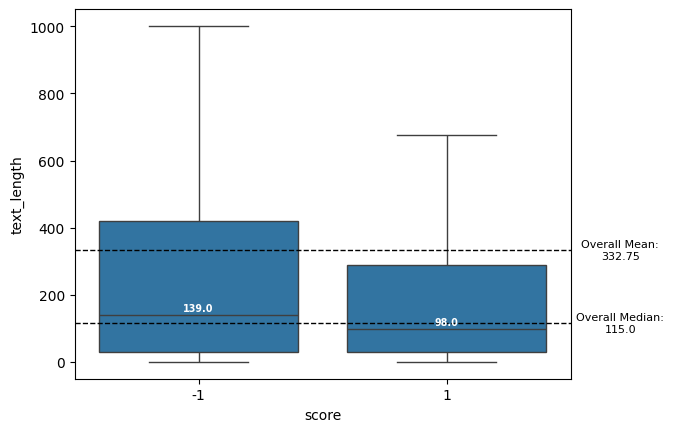

In [44]:
def generate_length_boxplot(df_stemmed: pd.DataFrame, col_text: str, col_score: str):

    from matplotlib import pyplot as plt
    import seaborn as sns

    df_stemmed['text_length'] = df_stemmed[col_text].apply(len)
    box_plot = sns.boxplot(data=df_stemmed, x=col_score, y='text_length', showfliers=False)

    medians = df_stemmed.groupby([col_score])['text_length'].median()
    vertical_offset = df_stemmed['text_length'].median() * 0.1

    for score in (-1, 1):
        box_plot.text(int(score>0), medians[score] + vertical_offset, medians[score],
                      horizontalalignment='center',size='x-small',color='w',weight='semibold')

    overall_median = df_stemmed['text_length'].median()
    box_plot.axhline(overall_median, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_median, f'Overall Median:\n{overall_median}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    overall_mean = round(df_stemmed['text_length'].mean(), 2)
    box_plot.axhline(overall_mean, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_mean, f'Overall Mean:\n{overall_mean}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    plt.show()

df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

df['text_length'] = df['text'].str.split().apply(len)
generate_length_boxplot(df, 'text', 'score')

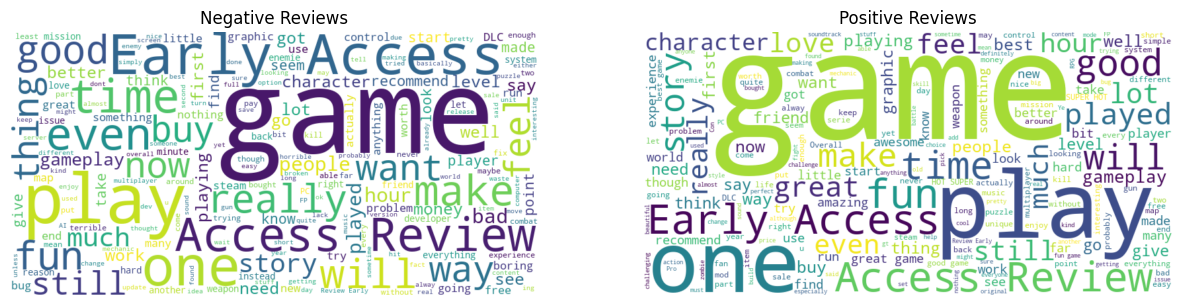

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def generate_wordcloud_freq(df: pd.DataFrame, text_col: str, score_col: str):
    pos_text = " ".join(df[df[score_col] == 1][text_col].astype(str))
    neg_text = " ".join(df[df[score_col] != 1][text_col].astype(str))

    pos_wc = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
    neg_wc = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(neg_wc, interpolation='bilinear')
    plt.title('Negative Reviews')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pos_wc, interpolation='bilinear')
    plt.title('Positive Reviews')
    plt.axis('off')

    plt.show()


df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

generate_wordcloud_freq(df, 'text', 'score')

# helper functions

In [7]:
def split_data(data, column_score, test_size=0.2, random_state=42):

    from sklearn.model_selection import train_test_split
    
    """
    Split data into training and testing sets

    Args:
    data: pandas dataframe
    column_score: string
    test_size: float
    """
    X = data.drop(columns=[column_score])
    y = data[column_score]
    y = y.replace(-1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_test, y_train, y_test

final_df = pd.read_csv('datasets/steam_50000_cleaned.csv')
X_train, X_test, y_train, y_test = split_data(final_df, 'score')

In [8]:
def metrics(y_test_np, y_pred):
    from matplotlib import pyplot as plt
    from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score

    f1_score = lambda precision, recall: 2 / (1/precision + 1/recall)
    precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred)
    max_f1 = 0
    best_threshold = 0
    best_recall = 0
    best_precision = 0
    for i in range(len(thresholds)):
        if f1_score(precision[i], recall[i]) > max_f1:
            max_f1 = f1_score(precision[i], recall[i])
            best_recall = recall[i]
            best_precision = precision[i]
            best_threshold = thresholds[i]

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label='PRC curve')
    plt.plot(best_recall, best_precision, marker = "x", color = "red", ms = 12, label = f"Best Threshold: {best_threshold}\nMax F1 Score: {max_f1}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    return average_precision_score(y_test_np, y_pred), accuracy_score(y_test_np, y_pred > best_threshold), best_threshold, max_f1

def evaluate_deep_learning_model(model, X_test_np, y_test_np):
    """
    Evaluate deep learning model
    """
    y_pred = model.predict(X_test_np).ravel()

    return metrics(y_test_np, y_pred)

# Baseline model

In [ ]:
# pip install transformers torch

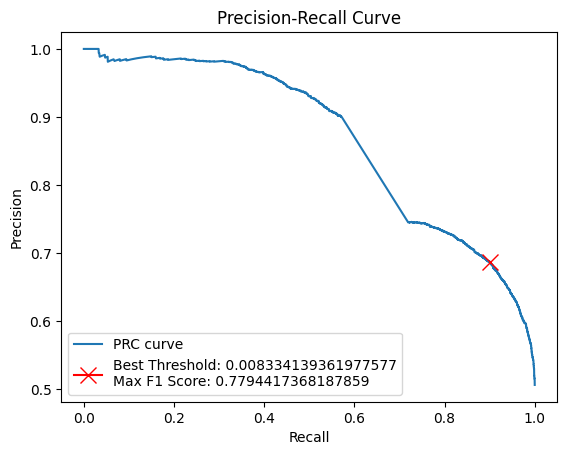

Average precision: 0.8576
Best threshold: 0.0083
Accuracy at best threshold: 0.7420
Max F1: 0.7794


In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def normalize_text(x):
    if isinstance(x, str):
        return x
    if isinstance(x, (list, tuple)):
        return " ".join(map(str, x))
    if pd.isna(x):
        return ""
    return str(x)

def bert_predict_proba(texts, batch_size=32, max_length=128):
    """
    Get probability of POSITIVE class for a list of texts
    using a pre-finetuned BERT model (no tuning).
    """
    all_probs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        encodings = {k: v.to(device) for k, v in encodings.items()}

        with torch.no_grad():
            outputs = model(**encodings)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            pos_probs = probs[:, 1]

        all_probs.extend(pos_probs.cpu().numpy())

    return np.array(all_probs)

final_df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

X_train, X_test, y_train, y_test = split_data(final_df, 'score')

texts_test = X_test["text"].tolist()
y_test_np = y_test.values

y_pred_proba = bert_predict_proba(texts_test, batch_size=32)

ap, acc, best_th, max_f1 = metrics(y_test_np, y_pred_proba)

print(f"Average precision: {ap:.4f}")
print(f"Best threshold: {best_th:.4f}")
print(f"Accuracy at best threshold: {acc:.4f}")
print(f"Max F1: {max_f1:.4f}")

In [ ]:
# pip install -q vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [8]:
def process_csv_vader(df):
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    # Initialize the SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()

    # Initialize lists to store data
    review_texts = []
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    compound_scores = []

    # Perform sentiment analysis and store scores in lists
    for review in df['review_text']:
        review = str(review)
        vs = analyzer.polarity_scores(review)

        review_texts.append(review)
        pos, neg, neu = vs['pos'], vs['neg'], vs['neu']
        positive_scores.append(pos)
        negative_scores.append(neg)
        neutral_scores.append(neu)
        compound_scores.append(((pos - neg) + 1) / 2)

    # Add sentiment scores and NPS categories to the DataFrame

    result_df = df.copy()

    result_df['positive_scores'] = positive_scores
    result_df['negative_scores'] = negative_scores
    result_df['neutral_scores'] = neutral_scores
    result_df['compound_scores'] = compound_scores

    return(result_df)

df = pd.read_csv('datasets/steam_dataset_50000.csv')
df = truncate(df, 'review_score', 2000)
vader_df = process_csv_vader(df)
df_to_csv(vader_df, 'datasets/steam_vader.csv')

C:\Users\DELL\AppData\Local\Temp\ipykernel_46768\2331639530.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)


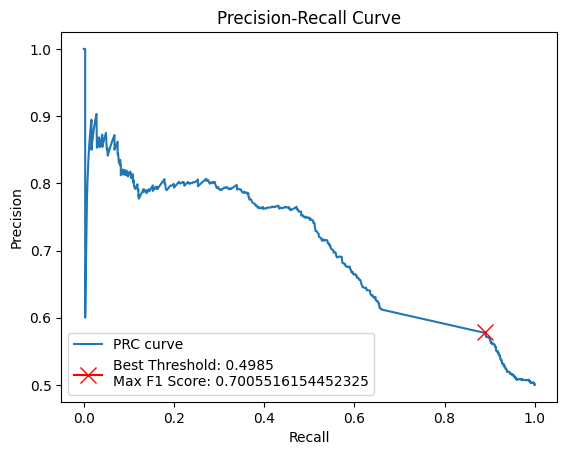

(np.float64(0.6991573059167995),
 0.62,
 np.float64(0.4985),
 np.float64(0.7005516154452325))

In [9]:
vader_df = pd.read_csv('datasets/steam_vader.csv')
metrics(vader_df['review_score'].replace(-1, 0).to_numpy(), vader_df['compound_scores'].to_numpy())

# Fine-tuned model

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
from matplotlib import pyplot as plt

# =========================================
# 2. Load cleaned data (text + score)
# =========================================

final_df = pd.read_csv(
    'datasets/steam_50000_cleaned.csv',
    keep_default_na=False,
    na_filter=False
)

final_df['text'] = final_df['text'].fillna("").astype(str)
final_df['score'] = final_df['score'].astype(int)

X_train_df, X_test_df, y_train, y_test = split_data(final_df, 'score')

texts_train = X_train_df['text'].tolist()
texts_test  = X_test_df['text'].tolist()
y_train_np  = y_train.values.astype(int)
y_test_np   = y_test.values.astype(int)

num_labels = 2  # binary sentiment (0 / 1)

# =========================================
# 3. Dataset + DataLoader
# =========================================

MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = TextDataset(texts_train, y_train_np, tokenizer)
test_dataset  = TextDataset(texts_test,  y_test_np, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# =========================================
# 4. Load base model (full fine-tune)
# =========================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)
model.to(device)

# Optimizer (full model trainable)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# =========================================
# 5. Training loop (full fine-tune)
# =========================================

num_epochs = 2  # you can increase to 3–5 later

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Training loss: {avg_loss:.4f}")

# =========================================
# 6. Evaluation with your metrics()
# =========================================

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].cpu().numpy()
        all_labels.extend(labels)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits  # (B, 2)
        probs = F.softmax(logits, dim=-1)[:, 1]  # prob of class 1
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

ap, acc, best_th, max_f1 = metrics(all_labels, all_probs)

print("=== DistilBERT full fine-tune on Steam ===")
print(f"Average precision: {ap:.4f}")
print(f"Best threshold:    {best_th:.4f}")
print(f"Accuracy @ best t: {acc:.4f}")
print(f"Max F1:            {max_f1:.4f}")


Using device: cpu
Epoch 1/2 - Training loss: 0.3896


KeyboardInterrupt: 